## GALERKIN PROJECTION OF THE 2D FORCED BOUSSINESQ EQUATIONS

In [1]:
# SET UP ENVIRONMENT

import pathlib
import time
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpi4py import MPI
from docopt import docopt
import os
from dedalus import public as de
from dedalus.extras import flow_tools
import logging
logger = logging.getLogger(__name__)

In [2]:
# DEFINE PARAMETERS

ReynoldsB    = 50.0                                                            # Buoyancy Reynolds Number
Prandtl      = 1.0                                                             # Prandtl Number
Froude       = 0.02                                                            # Froude Number
Lx, Lz       = (Froude*6.0*np.pi/0.34, 4.0*np.pi/3.0)                          # Box Size
Nz           = 512                                                            # No. of Gridpoints
stop_time    = 1.0                                                      # Sim. stop time

In [3]:
# LOGGER: RECORD INPUT PARAMETERS

if MPI.COMM_WORLD.rank == 0:
    logger.info("Running 2DBSQ simulation for Rb={:.3e}, Pr={:.3e}, Fr={:.3e}".format(ReynoldsB, Prandtl, Froude))

2024-12-04 13:13:07,844 __main__ 0/1 INFO :: Running 2DBSQ simulation for Rb=5.000e+01, Pr=1.000e+00, Fr=2.000e-02


In [4]:
# CREATE RESULTS FOLDER

path = 'results_galerkin/'
if MPI.COMM_WORLD.rank == 0:
    if not os.path.exists(path):
        os.mkdir(path)    

In [5]:
# CREATE BASES AND DOMAIN

z_basis = de.Fourier("z", Nz, interval=(0, Lz), dealias=3/2)
domain  = de.Domain([z_basis], grid_dtype=np.complex128)
z       = domain.grid(0)

In [6]:
# FORCING TERM

def perforce(*args):
    z = args[0].data
    m = 3.0
    R = ReynoldsB
    return 1.0*((m*m*m)/R)*np.cos(m*z)

def Forcing(*args, domain=domain, F=perforce):
    return de.operators.GeneralFunction(domain, layout='g', func=F, args=args)

de.operators.parseables['Kolmogorov'] = Forcing

In [7]:
# PROBLEM SETUP

problem = de.IVP(domain, variables=['xi0','psi0','b0','xi19','psi19','b19'])

In [8]:
# EQUATION ENTRY SUBSTITUTIONS

problem.parameters['Rb']                    = ReynoldsB
problem.parameters['Pr']                    = Prandtl
problem.parameters['Fr']                    = Froude
problem.parameters['Lx']                    = Lx
problem.parameters['Lz']                    = Lz
problem.parameters['k']                     = 2.0*np.pi/Lx
problem.substitutions['Lap(A, n)']          = 'dz(dz(A)) - ((n*k*Fr)**2.0)*A'
problem.substitutions['dx(A, n)']           = '1j*n*k*A'
problem.substitutions['Jp(A, B, C, D)']     = '1j*k*(A*dz(B) + C*dz(D))'
problem.substitutions['Jm(A, B, C, D)']     = '1j*k*(A*dz(B) - C*dz(D))'
problem.substitutions['J0(A, B, n)']        = 'n*Jp(conj(A), B, B, conj(A)) - n*Jp(A, conj(B), conj(B), A)' 

In [9]:
# VELOCITY SUBSTITUTIONS

problem.substitutions['u0']  = 'dz(psi0)'
problem.substitutions['w0']  = '-1.0*dx(psi0, 0)'
problem.substitutions['u19'] = 'dz(psi19)'
problem.substitutions['w19'] = '-1.0*dx(psi19, 19)'

In [10]:
# EVOLUTION EQUATIONS 
    
problem.add_equation("dt(xi0) - (1/Rb)*Lap(xi0, 0) = Kolmogorov(z) + J0(xi19, psi19, 19)")
problem.add_equation("dt(b0)  - (1/(Pr*Rb))*Lap(b0, 0) = J0(b19, psi19, 19)")
problem.add_equation("dt(xi19) + dx(b19, 19) - (1/Rb)*Lap(xi19, 19) = -19*Jm(xi19, psi0, psi19, xi0)")
problem.add_equation("dt(b19) - dx(psi19, 19) - (1/(Pr*Rb))*Lap(b19, 19) = -19*Jm(b19, psi0, psi19, b0)") 

In [11]:
# CONSTRAINT EQUATIONS
    
problem.add_equation("xi0 - Lap(psi0, 0) = 0", condition="(nz != 0)")
problem.add_equation("psi0 = 0", condition="(nz == 0)")
problem.add_equation("xi19 - Lap(psi19, 19) = 0")

In [12]:
# BUILD SOLVER

ts = de.timesteppers.SBDF4
solver = problem.build_solver(ts)
logger.info('Solver built')

2024-12-04 13:13:07,978 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.3e+01/s
2024-12-04 13:13:07,979 __main__ 0/1 INFO :: Solver built


In [13]:
# INITIAL CONDITIONS 

xi0   = solver.state['xi0']
psi0  = solver.state['psi0']
b0    = solver.state['b0']

xi19  = solver.state['xi19']
psi19 = solver.state['psi19']
b19   = solver.state['b19']

# INITIALIZE NOISE IN PARALLEL SAFE MANNER

gshape = domain.dist.grid_layout.global_shape(scales=1)
slices = domain.dist.grid_layout.slices(scales=1)
rand   = np.random.RandomState(seed=42)
noise  = rand.standard_normal(gshape)[slices]
    
# INITIALIZE MEAN FIELDS WITH BASIC STATE

xi0['g']  = 3.0*np.cos(3.0*z)
psi0['g'] = -(1/3)*np.cos(3.0*z)

# GET EIGENFUNCTIONS FROM FILE

eigenfuncs_real = h5py.File('initialize_galerkin_real.h5','r')
eigenfuncs_imag = h5py.File('initialize_galerkin_imag.h5','r')

# INITIALIZE MODE 19 WITH EIGENFUNCTIONS

xi19['g']  = eigenfuncs_real.get('xi19')[slices] + 1j*eigenfuncs_imag.get('xi19')[slices] 
psi19['g'] = eigenfuncs_real.get('psi19')[slices] + 1j*eigenfuncs_imag.get('psi19')[slices]
b19['g']   = eigenfuncs_real.get('b19')[slices] + 1j*eigenfuncs_imag.get('b19')[slices]

Text(0, 0.5, '')

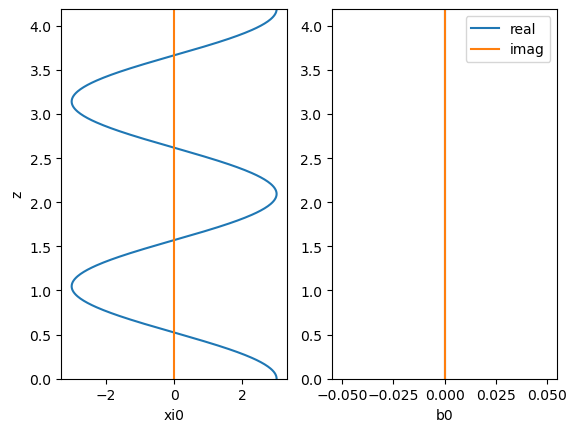

In [14]:
# PLOT INITIAL CONDITIONS - MODE 0

fig, axs = plt.subplots(1,2)

axs[0].plot(xi0['g'].real, np.transpose(z))
axs[0].plot(xi0['g'].imag, np.transpose(z))
axs[0].set_ylim(0, 4*np.pi/3)
axs[0].set_xlim(None, None)
axs[0].set_xlabel('xi0')
axs[0].set_ylabel('z')

axs[1].plot(b0['g'].real, np.transpose(z), label='real')
axs[1].plot(b0['g'].imag, np.transpose(z), label='imag')
axs[1].legend(loc="upper right")
axs[1].set_ylim(0, 4*np.pi/3)
axs[1].set_xlim(None, None)
axs[1].set_xlabel('b0')
axs[1].set_ylabel(None)

Text(0, 0.5, '')

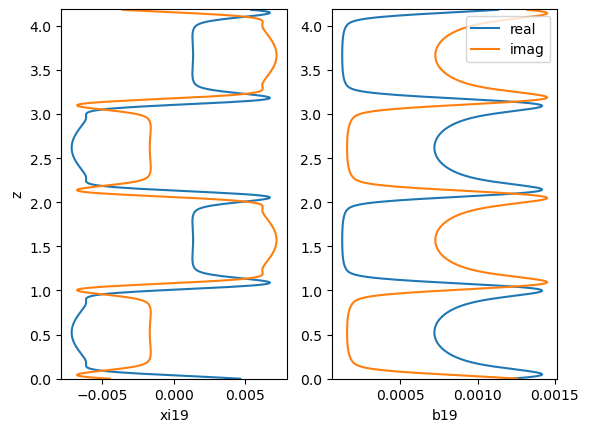

In [15]:
# PLOT INITIAL CONDITIONS - MODE 19

fig, axs = plt.subplots(1,2)

axs[0].plot(xi19['g'].real, np.transpose(z))
axs[0].plot(xi19['g'].imag, np.transpose(z))
axs[0].set_ylim(0, 4*np.pi/3)
axs[0].set_xlim(None, None)
axs[0].set_xlabel('xi19')
axs[0].set_ylabel('z')

axs[1].plot(b19['g'].real, np.transpose(z), label='real')
axs[1].plot(b19['g'].imag, np.transpose(z), label='imag')
axs[1].legend(loc="upper right")
axs[1].set_ylim(0, 4*np.pi/3)
axs[1].set_xlim(None, None)
axs[1].set_xlabel('b19')
axs[1].set_ylabel(None)

In [16]:
# INTEGRATION PARAMETERS
    
dt = 0.00001
solver.stop_sim_time = stop_time

In [17]:
# FLOW TOOLS

flow = flow_tools.GlobalFlowProperty(solver, cadence = 100)
flow.add_property("xi0*conj(xi0)", name="buoy")

In [18]:
# CFL 

CFL = flow_tools.CFL(solver, initial_dt=dt, cadence=10, safety=0.1, max_change=2, min_change=0.5, max_dt=0.05, threshold=0.05)
CFL.add_velocity('w19',0)

In [19]:
# SET UP STORAGE 

xi0.set_scales(1)
b0.set_scales(1)
xi19.set_scales(1)
b19.set_scales(1)

xi0_list  = [np.copy(xi0['g'])]
b0_list   = [np.copy(b0['g'])]
xi19_list = [np.copy(xi19['g'])]
b19_list  = [np.copy(b19['g'])]
t_list    = [solver.sim_time]

In [20]:
# MAIN LOOP

try:  
    logger.info('Starting loop')
    start_time = time.time()
    while solver.proceed:
        
        timestep = CFL.compute_dt()
        solver.step(timestep)
        if (solver.iteration-1) % 5 == 0:
            logger.info('Iteration: %i, Time: %e, dt: %e, max(xi0): %e' %(solver.iteration, solver.sim_time, timestep, flow.max('buoy'))) 
            xi0.set_scales(1)
            b0.set_scales(1)
            xi0_list.append(np.copy(xi0['g']))
            b0_list.append(np.copy(b0['g']))
            xi19.set_scales(1)
            b19.set_scales(1)
            xi19_list.append(np.copy(xi19['g']))
            b19_list.append(np.copy(b19['g']))
            t_list.append(solver.sim_time)    
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    end_time = time.time()
    logger.info('Iterations: %i' %solver.iteration)
    logger.info('Sim end time: %f' %solver.sim_time)
    logger.info('Run time: %.2f sec' %(end_time-start_time))
    logger.info('Run time: %f cpu-hr' %((end_time-start_time)/60/60*domain.dist.comm_cart.size))


2024-12-04 13:13:08,489 __main__ 0/1 INFO :: Starting loop
2024-12-04 13:13:08,820 __main__ 0/1 INFO :: Iteration: 1, Time: 1.000000e-05, dt: 1.000000e-05, max(xi0): 9.000000e+00
2024-12-04 13:13:08,838 __main__ 0/1 INFO :: Iteration: 6, Time: 6.000000e-05, dt: 1.000000e-05, max(xi0): 9.000000e+00
2024-12-04 13:13:08,854 __main__ 0/1 INFO :: Iteration: 11, Time: 1.100000e-04, dt: 1.000000e-05, max(xi0): 9.000000e+00
2024-12-04 13:13:08,872 __main__ 0/1 INFO :: Iteration: 16, Time: 2.100000e-04, dt: 2.000000e-05, max(xi0): 9.000000e+00
2024-12-04 13:13:08,888 __main__ 0/1 INFO :: Iteration: 21, Time: 3.100000e-04, dt: 2.000000e-05, max(xi0): 9.000000e+00
2024-12-04 13:13:08,907 __main__ 0/1 INFO :: Iteration: 26, Time: 5.100000e-04, dt: 4.000000e-05, max(xi0): 9.000000e+00
2024-12-04 13:13:08,922 __main__ 0/1 INFO :: Iteration: 31, Time: 7.100000e-04, dt: 4.000000e-05, max(xi0): 9.000000e+00
2024-12-04 13:13:08,941 __main__ 0/1 INFO :: Iteration: 36, Time: 1.110000e-03, dt: 8.000000e-05

/mnt/home/chini/as1751-new/.conda/envs/dedalus/lib/python3.8/site-packages/dedalus/extras/flow_tools.py:37: ComplexWarning: Casting complex values to real discards the imaginary part
  self._scalar_buffer[0] = local_scalar


2024-12-04 13:13:09,026 __main__ 0/1 INFO :: Iteration: 61, Time: 6.310000e-03, dt: 3.200000e-04, max(xi0): 9.000000e+00
2024-12-04 13:13:09,045 __main__ 0/1 INFO :: Iteration: 66, Time: 9.510000e-03, dt: 6.400000e-04, max(xi0): 9.000000e+00
2024-12-04 13:13:09,061 __main__ 0/1 INFO :: Iteration: 71, Time: 1.271000e-02, dt: 6.400000e-04, max(xi0): 9.000000e+00
2024-12-04 13:13:09,079 __main__ 0/1 INFO :: Iteration: 76, Time: 1.911000e-02, dt: 1.280000e-03, max(xi0): 9.000000e+00
2024-12-04 13:13:09,095 __main__ 0/1 INFO :: Iteration: 81, Time: 2.551000e-02, dt: 1.280000e-03, max(xi0): 9.000000e+00
2024-12-04 13:13:09,113 __main__ 0/1 INFO :: Iteration: 86, Time: 3.831000e-02, dt: 2.560000e-03, max(xi0): 9.000000e+00
2024-12-04 13:13:09,130 __main__ 0/1 INFO :: Iteration: 91, Time: 5.111000e-02, dt: 2.560000e-03, max(xi0): 9.000000e+00
2024-12-04 13:13:09,145 __main__ 0/1 INFO :: Iteration: 96, Time: 6.391000e-02, dt: 2.560000e-03, max(xi0): 9.000000e+00
2024-12-04 13:13:09,161 __main__

In [21]:
# CONVERT LISTS TO ARRAYS

xi0_array = np.array(xi0_list)
b0_array  = np.array(b0_list)
xi19_array = np.array(xi19_list)
b19_array  = np.array(b19_list)
t_array    = np.array(t_list)

Text(0, 0.5, '')

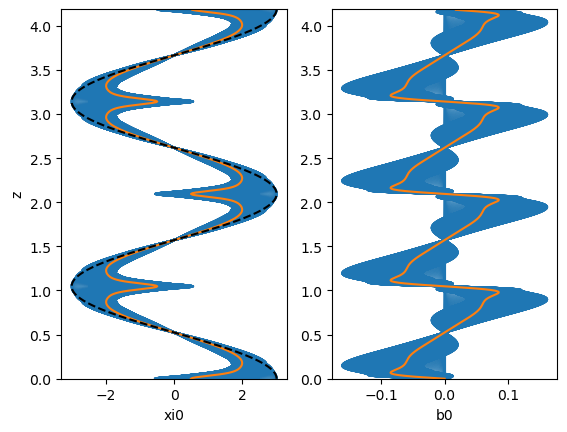

In [22]:
# PLOT SOLUTIONS - MODE 0

fig, axs = plt.subplots(1,2)
alpha = np.linspace(0.2, 1, len(xi0_array))
color = ('C0',) * (len(xi0_array)-1) + ('C1',)

for i in range(0,len(xi0_array)):
    axs[0].plot(xi0_array[i,:].real, np.transpose(z), c=color[i], alpha=alpha[i])
axs[0].plot(3.0*np.cos(3.0*np.transpose(z)), np.transpose(z), linestyle='dashed', linewidth=1.5, color='black')
axs[0].set_ylim(0, 4*np.pi/3)
axs[0].set_xlim(None, None)
axs[0].set_xlabel('xi0')
axs[0].set_ylabel('z')

for i in range(0,len(xi0_array)):
    axs[1].plot(b0_array[i,:].real, np.transpose(z), c=color[i], alpha=alpha[i])
axs[1].set_ylim(0, 4*np.pi/3)
axs[1].set_xlim(None, None)
axs[1].set_xlabel('b0')
axs[1].set_ylabel(None)

Text(0, 0.5, '')

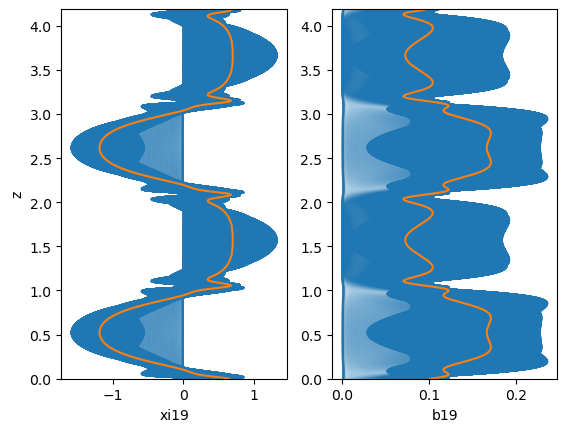

In [23]:
# PLOT SOLUTIONS - MODE 19

fig, axs = plt.subplots(1,2)
alpha = np.linspace(0.2, 1, len(xi0_array))
color = ('C0',) * (len(xi19_array)-1) + ('C1',)

for i in range(0,len(xi19_array)):
    axs[0].plot(xi19_array[i,:].real, np.transpose(z), c=color[i], alpha=alpha[i])
axs[0].set_ylim(0, 4*np.pi/3)
axs[0].set_xlim(None, None)
axs[0].set_xlabel('xi19')
axs[0].set_ylabel('z')

for i in range(0,len(xi19_array)):
    axs[1].plot(b19_array[i,:].real, np.transpose(z), c=color[i], alpha=alpha[i])
axs[1].set_ylim(0, 4*np.pi/3)
axs[1].set_xlim(None, None)
axs[1].set_xlabel('b19')
axs[1].set_ylabel(None)

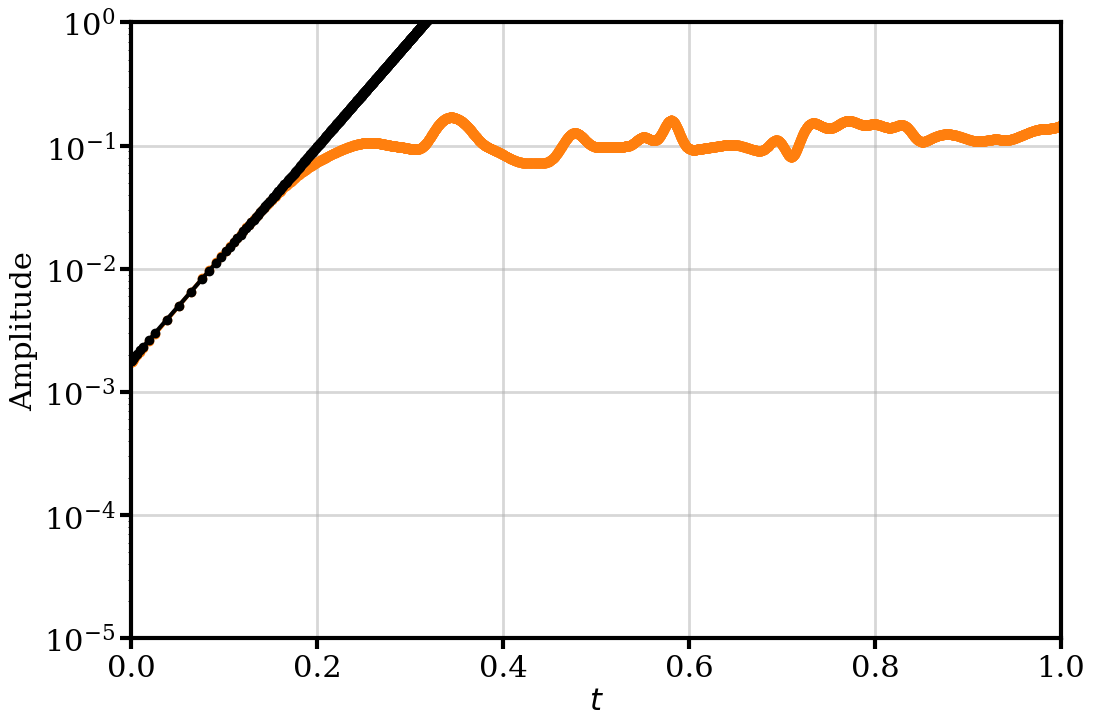

In [26]:
# TRACK GROWTH RATE 

b19_slice = b19_array[:, 384]
check = 0.0018*np.exp(20*t_array)
plt.rcParams.update({'font.size': 22, 'font.family': 'serif', 'axes.linewidth': 3, 'grid.linewidth': 2, 'grid.alpha': 0.5})
fig = plt.figure(figsize=(12, 8))
plt.axhline(y=0, color='k', linestyle='--', linewidth=3, alpha=0.5)
plt.plot(t_list, np.abs(b19_slice), '.-', c=color[i], alpha=alpha[i], linewidth=3, markersize=12)
plt.plot(t_list, check, '.-', c='k', alpha=alpha[i], linewidth=3, markersize=12)
plt.xlim(0, 1)
plt.ylim(1e-5, 1e-0)
plt.xlabel(r"$t$")
plt.ylabel(r"Amplitude")
plt.grid()
# plt.gca().set_aspect(1./plt.gca().get_data_ratio())
plt.gca().tick_params('both', length=8, width=3, which='major')
plt.gca().set_yscale('log')

In [25]:
np.exp(0.4)

1.4918246976412703